<a href="https://colab.research.google.com/github/rpdieego/Kaggle_DigitRecognizer/blob/master/Kaggle_DigitRecognizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kaggle Competition - Digit Recognizer

[Click here to check the related page on Kaggle for this competition](https://www.kaggle.com/c/digit-recognizer)



## Step 1 - Defining the Problem

MNIST ("Modified National Institute of Standards and Technology") is the de facto “hello world” dataset of computer vision. Since its release in 1999, this classic dataset of handwritten images has served as the basis for benchmarking classification algorithms. As new machine learning techniques emerge, MNIST remains a reliable resource for researchers and learners alike.

**Goal**

In this competition, our goal is to correctly identify digits from a dataset of tens of thousands of handwritten images.

**Practice Skills**

*   Computer vision fundamentals including simple neural networks

*   Classification methods such as SVM and K-nearest neighbors

**Metric**

This competition is evaluated on the categorization accuracy of our predictions (the percentage of images we get correct).

# Step 2 - Obtaining the Data

The data files train.csv and test.csv contain gray-scale images of hand-drawn digits, from zero through nine.

Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255, inclusive.

The training data set, (train.csv), has 785 columns. The first column, called "label", is the digit that was drawn by the user. The rest of the columns contain the pixel-values of the associated image.

Each pixel column in the training set has a name like pixelx, where x is an integer between 0 and 783, inclusive. To locate this pixel on the image, suppose that we have decomposed x as x = i * 28 + j, where i and j are integers between 0 and 27, inclusive. Then pixelx is located on row i and column j of a 28 x 28 matrix, (indexing by zero).

The test data set, (test.csv), is the same as the training set, except that it does not contain the "label" column.

![alt text](https://github.com/rpdieego/Kaggle_DigitRecognizer/blob/master/image_data_01.JPG?raw=true)



In [0]:
# import relevant packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import matplotlib.cm as cm  
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPool2D
from keras.utils import np_utils




In [0]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
# Import train.csv from Google Drive

link_train = 'https://drive.google.com/open?id=1rL_7BlY4JnUQhKFn38LzLy4thyUhaevG'

fluff, id = link_train.split('=')
print (id) # Verify that we have everything after '='

downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('train.csv')  
train_df = pd.read_csv('train.csv')

1rL_7BlY4JnUQhKFn38LzLy4thyUhaevG


In [0]:
# Import test.csv from Google Drive

link_test = 'https://drive.google.com/open?id=1x94HpdwCZwqvlwo9i6YO0a0c83yMbKJG'

fluff, id = link_test.split('=')
print (id) # Verify that we have everything after '='

downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('test.csv')  
test_df = pd.read_csv('test.csv')

1x94HpdwCZwqvlwo9i6YO0a0c83yMbKJG


In [0]:
# Checking the dimensions of the Datasets

print("Train Dataset \n Variables:\t{}\n Inputs:\t{}".format(train_df.shape[1], train_df.shape[0]))
print("\n")
print("Test Dataset \n Variables:\t{}\n Inputs:\t{}".format(test_df.shape[1], test_df.shape[0]))

Train Dataset 
 Variables:	785
 Inputs:	42000


Test Dataset 
 Variables:	784
 Inputs:	28000


In [0]:
# Importing TensorFlow

from __future__ import absolute_import, division, print_function, unicode_literals
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf


TensorFlow is already loaded. Please restart the runtime to change versions.


# Step 3 - Checking and Preprocessing the Data

**Missing Values**

Lets check if there are any missing values in both of the dataframes (a missing value would mean that one of the digit images is somehow corrupted).


In [0]:
# Checking missing values on the train dataframe

train_df.isnull().any().describe()

count       785
unique        1
top       False
freq        785
dtype: object

In [0]:
# Checking missing values on the test dataframe

test_df.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

**Plotting some images to check the data**

Let`s plot some of the images of our training dataset to visually check the data

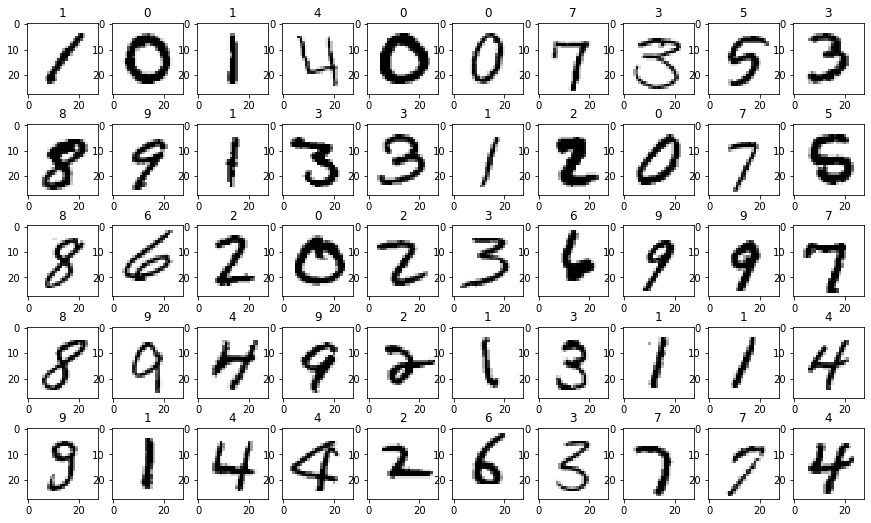

In [0]:
y_train_pd = train_df.iloc[:,0].values
X_train_pd = train_df.iloc[:,1:].values.reshape(-1,28,28,1)


#plot some images and labels

plt.figure(figsize=(15,9))
for i in range(50):
    plt.subplot(5,10,1+i)
    plt.title(y_train_pd[i])
    plt.imshow(X_train_pd[i].reshape(28,28), cmap=cm.binary)

**Converting the Output Labels**

For our neural network model, it`s necessary to convert the labels from scalars to one-hot vectors.

It means:

*   0 -> [1 0 0 0 0 0 0 0 0 0]
*   1 -> [0 1 0 0 0 0 0 0 0 0]
*   2 -> [0 0 1 0 0 0 0 0 0 0]
*   3 -> [0 0 0 1 0 0 0 0 0 0]
*   4 -> [0 0 0 0 1 0 0 0 0 0]
*   5 -> [0 0 0 0 0 1 0 0 0 0]
*   6 -> [0 0 0 0 0 0 1 0 0 0]
*   7 -> [0 0 0 0 0 0 0 1 0 0]
*   8 -> [0 0 0 0 0 0 0 0 1 0]
*   9 -> [0 0 0 0 0 0 0 0 0 1]




In [0]:
def dense_to_one_hot(labels_dense, num_classes):
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
    return labels_one_hot


# one-hot encoded labels
y_train = dense_to_one_hot(train_df.iloc[:,0].values, 10).astype(np.uint8)


In [0]:
# Saving the images into the variable X_train

X_train = train_df.drop(labels = ["label"], axis = 1)

X_test = test_df

**Checking if the dataset is imbalanced**

As imbalanced datasets are a great problem for Machine Learning algorithims in general, we shall check how the targets are distributed:

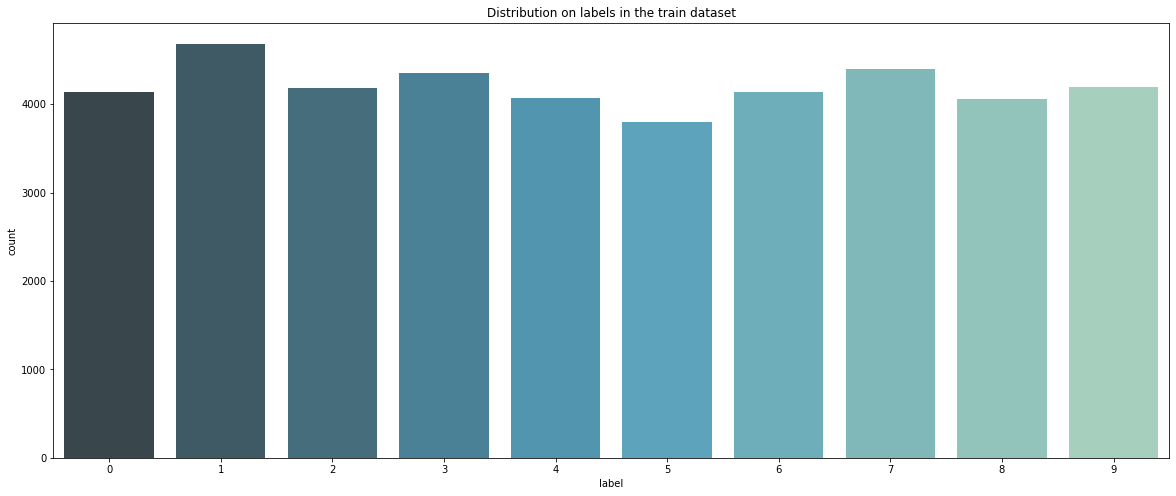

In [0]:
# Labels distribution in the train dataset
plt.figure(figsize=(20,8));plt.title('Distribution on labels in the train dataset')
labels_plot = sns.countplot(train_df['label'], palette="GnBu_d")

There are a similar number of ocorrences for the 10 digits in the train dataset, so lack of balance shall not be a problem to our model.

**Normalization**

Normally, we would like to scale our data in some way to make the result more numerically stable. In this case, we will simply prefer to have inputs between 0 and 1.

Since the possible values for the inputs are 0 to 255 (256 different shades of grey), we shall divide each element by 255, getting the desirable result for our normalization : all elements are in the range between 0 and 1:


In [0]:
# Normalize the Data

X_train = X_train / 255.0

X_test = X_test / 255.0


**Reshape the images**

Let`s reshape the images stored into 1D vectors of 784 values to 28 x 28 x 1 matrices:

In [0]:
# Reshape X_train data into matrices ( 28 x 28 x 1)
X_train = X_train.values.reshape(-1,28,28,1)

# Reshape X_test data into matrices ( 28 x 28 x 1)
X_test = X_test.values.reshape(-1,28,28,1)

**Validation Dataset**

As Kaggle only provided us training and test datasets, we shall need to create the validation dataset on our own:

[Validation Datasets](https://en.wikipedia.org/wiki/Training,_validation,_and_test_sets)

I`m going to use 10% of the samples of our training dataset to create the validation dataset.

In [0]:
# Spliting the training and validation datasets

np.random.seed(2)
X_train, X_validation, y_train, y_validation = train_test_split(X_train,y_train, test_size = 0.1, random_state=2)

**Defining the Batch Size**

I`m going to use mini batch gradient descent to train my model, as it's one of the most efficient ways to perform deep learning, since the tradeoff of accuracy and speed is optimal.

[Introduction to mini batch gradient descent](https://machinelearningmastery.com/gentle-introduction-mini-batch-gradient-descent-configure-batch-size/)

According to some tests and studies (see link above), a good default for batch size might be 32, so let`s follow with this:

In [0]:
# Defining the batch size
batch_size_num = 32

# **Step 4 - Building the Convolutional Neural Network (CNN) with Keras**

**Outline the Model**

I`ve chosen the following structure to our convolutional neural network:

*Feature Extraction*
*   Convolutional Layer 1 - 32 feature maps using a 5x5 filter and stride 1
*   Subsampling Layer 1 - Max pooling using 2x2 filter and stride 2
*   Convolutional Layer 2 - 64 feature maps using 5x5 filter and stride 1
*   Subsampling Layer 2 - max pooling using 2x2 filter and stride 2
*   Dropout Layer - 25%

*Classification*
*   Flatten Layer
*   Dense Layer 1 -> ReLu : [.,64]
*   Dense Layer 2 -> ReLu : [.,64]
*   Dropout Layer - 25%
*   Output Layer -> Softmax : [.,10] - As we have 10 possible digits on the images







In [0]:
# Hyperparameters

# Convolutional Layer 1
conv_layer_1_filters = 32

# Convolutional Layer 2
conv_layer_2_filters = 64

# Dropout Rate
dropout_rate = 0.25

#Dense Layer
dense_layer_size = 64

#Output Layer
output_size = 10

In [0]:
# creating the model object

model = Sequential()

# Convolutional Layer 1
model.add(Conv2D(
                 filters = conv_layer_1_filters,
                 kernel_size = (5,5),
                 padding = 'Same',
                 activation = 'relu',
                 input_shape = (28,28,1)
                 ))

# Subsampling Layer 1
model.add(MaxPool2D(pool_size=(2,2)))

# Convolutional Layer 2
model.add(Conv2D(
                 filters = conv_layer_2_filters,
                 kernel_size = (5,5),
                 padding = 'Same',
                 activation = 'relu'
                 ))

# Subsampling Layer 2
model.add(MaxPool2D(pool_size=(2,2)))

# Dropout Layer 1
model.add(Dropout(dropout_rate))

# Flatten Layer
model.add(Flatten())

# Dense Layer 1
model.add(Dense(
                 dense_layer_size,
                 activation = 'relu'
                 ))

# Dense Layer 2
model.add(Dense(
                 dense_layer_size,
                 activation = 'relu'
                 ))

# Dropout Layer 2
model.add(Dropout(dropout_rate))

# Output Layer
model.add(Dense(
                output_size,
                activation = 'softmax'
               ))






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


**Optimizer**

I`ve chosen [Adam](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/) as our optimizer function.

**Loss Function**

We are going to use categorical cross-entropy as the loss function.


**Metric Function**

As the metrics chosen by kaggle to this competition is the accuracy, that`s our pick to the  metric function.

In [0]:
model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])

**Number of Epochs**

In [0]:
# defining the number of epochs
num_epochs = 5

**Defining the Batch Size**

I`m going to use mini batch gradient descent to train my model, as it's one of the most efficient ways to perform deep learning, since the tradeoff of accuracy and speed is optimal.

[Introduction to mini batch gradient descent](https://machinelearningmastery.com/gentle-introduction-mini-batch-gradient-descent-configure-batch-size/)

According to some tests and studies (see link above), a good default for batch size might be 32, so let`s follow with this:

In [0]:
# Defining the batch size
batch_size_num = 32

**Training**

In [0]:
trained_model = model.fit(X_train,
                 y_train,
                 epochs=num_epochs,
                 batch_size = batch_size_num,
                 validation_data=(X_validation,y_validation),
                 verbose=2
                 )

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 37800 samples, validate on 4200 samples
Epoch 1/5





 - 93s - loss: 0.2385 - acc: 0.9251 - val_loss: 0.0809 - val_acc: 0.9726
Epoch 2/5
 - 92s - loss: 0.0695 - acc: 0.9787 - val_loss: 0.0552 - val_acc: 0.9838
Epoch 3/5
 - 93s - loss: 0.0511 - acc: 0.9848 - val_loss: 0.0430 - val_acc: 0.9876
Epoch 4/5
 - 93s - loss: 0.0415 - acc: 0.9877 - val_loss: 0.0433 - val_acc: 0.9864
Epoch 5/5
 - 92s - loss: 0.0334 - acc: 0.9898 - val_loss: 0.0454 - val_acc: 0.9886


# Step 5 - Evaluating our model

Let`s check the final loss and accuracy of the model for both training and validation data  and also it's curves during the training procedure:


In [0]:
# Train final loss and accuracy

final_loss_train, final_acc_train = model.evaluate(X_train, y_train, verbose = 0)
print("Train \n Final Loss: {0:.4f}\n Final Accuracy: {1:.4f}".format(final_loss_train,final_acc_train))

Train 
 Final Loss: 0.0174
 Final Accuracy: 0.9943


In [0]:
# Validation final loss and accuracy

final_loss_val, final_acc_val = model.evaluate(X_validation, y_validation, verbose = 0)
print("Validation \n Final Loss: {0:.4f}\n Final Accuracy: {1:.4f}".format(final_loss_val,final_acc_val))

Validation 
 Final Loss: 0.0454
 Final Accuracy: 0.9886


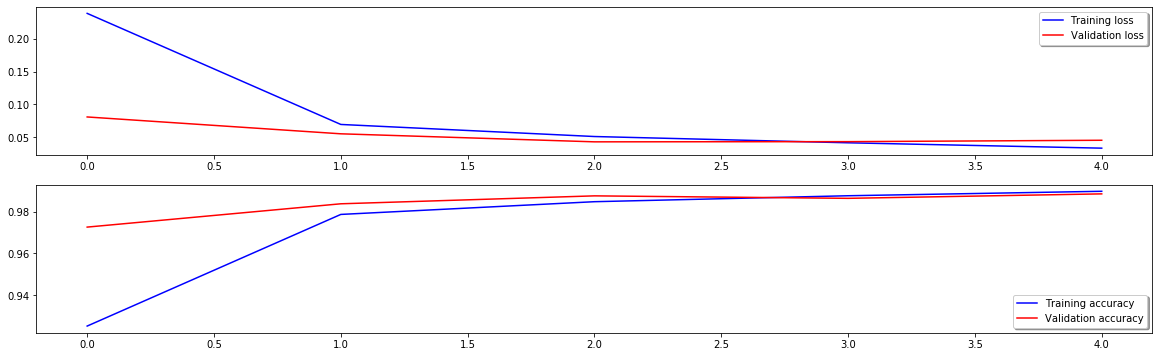

In [0]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1,figsize = (20,6))
ax[0].plot(trained_model.history['loss'], color='b', label="Training loss")
ax[0].plot(trained_model.history['val_loss'], color='r', label="Validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(trained_model.history['acc'], color='b', label="Training accuracy")
ax[1].plot(trained_model.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

As we can see on the graphs above, the validation loss crosses the training loss close to the third epoch, and the difference tends to increase, as the training loss keeps decreasing along the epochs.

It means that, a higher number of epochs would lead the model to be overfitted to the training data, and then loose the capability of generalizing and perform well with the test data, which is our real goal here.

**Confusion Matrix**

Let`s plot a confusion matrix to compare the digits predicted to the validation dataset with the true labels and check if there are any digit which is being missed way more than the others and also try to check for any drawbacks on our model:

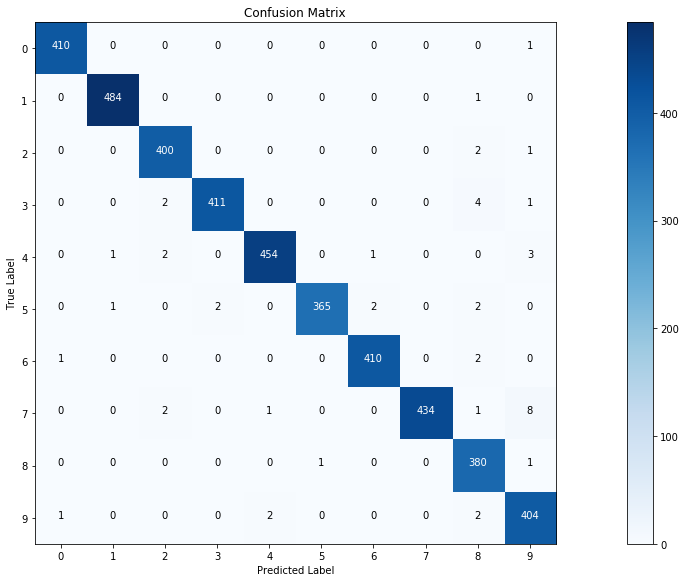

In [0]:
# Function to define the confusion matrix

def plot_conf_matrix (cm, classes, normalize=False, title = 'Confusion Matrix',cmap = 'Blues'):
  plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes)
  plt.yticks(tick_marks, classes)

  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
  threshold = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j,i, cm[i,j],
             horizontalalignment = "center",
             color="white" if cm[i, j] > threshold else "black")
  plt.tight_layout()
  plt.ylabel('True Label')
  plt.xlabel('Predicted Label')

# Predict the Values for the validation set
y_hat_val = model.predict(X_validation)

# Convert % predictions into the most probable label
y_hat_val_classes = np.argmax(y_hat_val,axis = 1)

# Convert the one-hot encoded validation observations into labels
y_validation_classes = np.argmax(y_validation,axis = 1)

# Computing the confusion matrix

conf_mtx = confusion_matrix(y_validation_classes,y_hat_val_classes)

# Plotting the confusion matrix
fig, ax =plt.subplots(1, figsize = (20,8))
ax = plot_conf_matrix (conf_mtx, classes = range(10))


In general, we have got really good results (above 98% accuracy) for all the digits


*   *Label 0* - 410 right predictions out of 411 samples - **99.76 %** accuracy
*   *Label 1* - 484 right predictions out of 485 samples - **99.78 %** accuracy
*   *Label 2* - 400 right predictions out of 403 samples - **99.25 %** accuracy
*   *Label 3* - 411 right predictions out of 418 samples - **98.35 %** accuracy
*   *Label 4* - 454 right predictions out of 461 samples - **98.48 %** accuracy
*   *Label 5* - 365 right predictions out of 372 samples - **98.11 %** accuracy
*   *Label 6* - 410 right predictions out of 413 samples - **99.27 %** accuracy
*   *Label 7* - 434 right predictions out of 446 samples - **97.31 %** accuracy
*   *Label 8* - 380 right predictions out of 382 samples - **99.47 %** accuracy
*   *Label 9* - 404 right predictions out of 409 samples - **98.77 %** accuracy




*Label with the highest accuracy*

The label with the hights accuracy was *1*, with only one mistaken prediction

*Label with the lowest accuracy*

And the label with the worst results was *7*, where the majority of the mistaken predictions said it was a *9* instead of a *7*.

**Most significant errors**

Let`s check the top ten most signiicant errors in ours predictions to check which images our model is strugling to identify.

To do that, I`m going to check the predictions where the given probability of the true digit are the smallest.

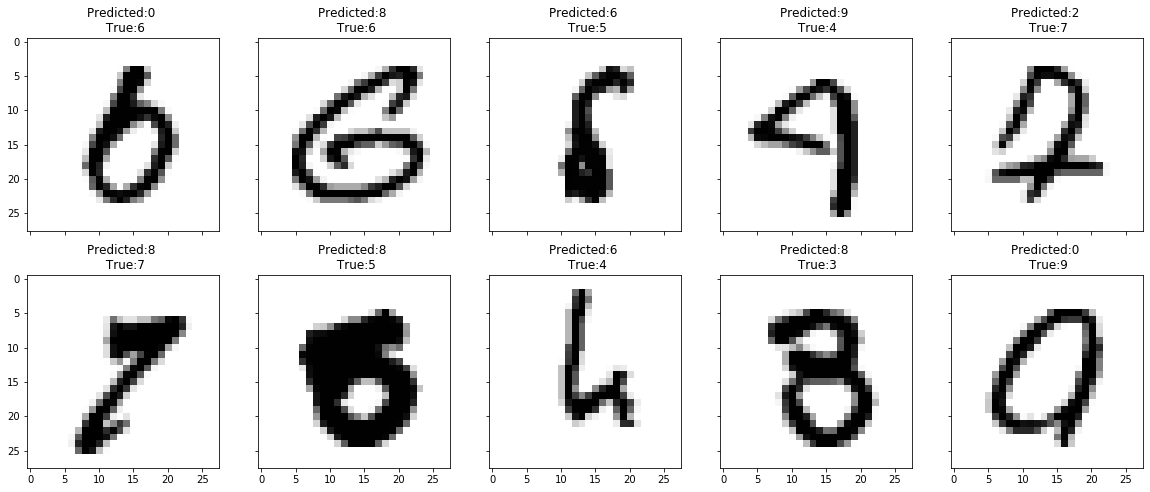

In [0]:
# Declaring the error variables (Predicted - True)

errors = (y_hat_val_classes - y_validation_classes != 0)

y_hat_val_classes_errors = y_hat_val_classes[errors]

y_hat_val_errors = y_hat_val[errors]

y_validation_errors = y_validation_classes[errors]

X_validation_errors = X_validation[errors]

# Function to plot the images where our model had thhe most significant errors
def disp_errors(errors_index,img_errors,pred_errors, obs_errors):
    n = 0
    nrows = 2
    ncols = 5
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True, figsize = (20,8))
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error].reshape((28,28))),cmap=cm.binary)
            ax[row,col].set_title("Predicted:{} \n True:{}".format(pred_errors[error],obs_errors[error]))
            n += 1


# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(y_hat_val_errors,axis = 1)


# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(y_hat_val_errors, y_validation_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 10 most significant errors 
most_important_errors = sorted_dela_errors[-10:]

# Plot
disp_errors(most_important_errors, X_validation_errors, y_hat_val_classes_errors, y_validation_errors)

By looking at these images where our model had the most significant errors, I could say that even a human being could miss a guess at some of them.

Hence, I would say that our model is far from making silly mistakes.

# Step 6 - Evalutaing the results with the test dataset

At this step, let`s use the model to predict the labels using the images of the test dataset and submit our results on the Kaggle website:

**Predicting the labels using the test dataset**

In [0]:
# predicting with the test dataset
y_hat_test = model.predict(X_test)

# getting the index of the hightest probability
y_hat_test = np.argmax(y_hat_test, axis = 1)

# Creating a PanDas dataframe with the results

results = pd.Series(y_hat_test, name = "Label")

submission = pd.concat([pd.Series(range(1,28001), name = "ImageId"),results], axis = 1)


In [0]:
submission.head(10)

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3
5,6,7
6,7,0
7,8,3
8,9,0
9,10,3


In [0]:
# Saving the .csv submission file
submission.to_csv("mnist_kaggle_submission.csv", index = False)

**Kaggle Results**

I`ve had the following score after my submission:

![alt text](https://github.com/rpdieego/Kaggle_DigitRecognizer/blob/master/Kaggle_Results.JPG?raw=true)






# Step 7 - Conclusions

Summarizing, our model had the following results:

*   **Training** : 99.43 % accuracy
*   **Validation** : 98.86 % accuracy
*   **Test** : 98.66 % accuracy 

There are not bad results at all. Validation and Test results are pretty similar, and besides the fact of the training accuracy being slightly higher, overfit doesn`t seem to be our issue here, judging by the most significant mistakes our model had at the validation dataset.

The predictions that our model haven`t got right were at the most intrigous and ambiguos images, which even an human being could be confused at. For this particular reason, I believe that, in order to achieve better results, it would be necessary to spend some more effort on the image preprocessing, applying techniques like data augmentation (rotating, zooming and shifting the images).

